In [108]:
# Dashboard
import plotly
import plotly.express as px
import plotly.graph_objects as go

import dash
import dash_core_components as dcc
import dash_html_components as html
import dash_bootstrap_components as dbc
from dash.dependencies import Input, Output

import json
import base64

# Classicals
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn.model_selection import cross_validate

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

In [109]:
from os import getcwd, path
data_path = path.join(path.split(getcwd())[0], '00_data')
# to join a file with a path : path.join(data_path, 'name.csv')


In [110]:
# Preperation
df_1 = pd.read_csv(path.join(data_path, 'dashboard_airlinequality.csv'))
df_2 = pd.read_csv(path.join(data_path, 'dashboard_tab2.csv'))
df_2_2 = pd.read_csv(path.join(data_path, 'wordcloud_data.csv'))
cols_15 = ['Seat Comfort', 'Cabin Staff Service', 'Ground Service', 
            'Value For Money', 'Food & Beverages', 'Inflight Entertainment']
li_seat_type = ['Economy Class', 'Business Class', 'Premium Economy', 'First Class']
li_type_of_traveller = ['Solo Leisure', 'Business', 'Family Leisure', 'Couple Leisure']
li_flight_length = ['Short-Haul', 'Middle-Haul', 'Long-Haul']

## Tab1: What contribute to customer satisfaction?

In [111]:
# A function to output the chart
def output_chart_1(df = df_1,
                 seat_type = ['Economy Class'], 
                 type_of_travaller = ['Solo Leisure'], 
                 stop = [False],
                 flight_length = ['Short-Haul']):
    
    # Select data by category
    mask = (df['Seat Type'].isin(seat_type)) &\
            (df['Type Of Traveller'].isin(type_of_travaller)) &\
            (df['Is_stop'].isin(stop)) &\
            (df['Flight Length'].isin(flight_length))
    df = df[mask]
    
    # Fill nans with mean
    df = df.fillna(df.mean())
            
    # Make X and y
    X = df[cols_15]
    y = df['Recommended']
    
    # Calculate coefficients
    model = linear_model.LogisticRegression(solver='lbfgs', C=0.05)
    model.fit(X, y)
    df_coef = pd.DataFrame({'Feature':X.columns.to_list(),
                        'Coef':model.coef_.tolist()[0]})
    df_coef = df_coef.sort_values(['Coef'])
    df_coef['Importance'] = np.exp(df_coef['Coef']) - 1
    
    # Calculate some statistics
    model_accuracy = cross_validate(model, X, y, cv=5, return_train_score=True)['test_score'].mean()
    n_samples = X.shape[0]
    print(model_accuracy, n_samples)
    
    # Visualize coefficients
    # Intepretation: If the coefficient for Inflight Entertainment is 0.2,
    #                an increase in a star in Inflight Entertainment will make a customer 22% (exp(0.2)=1.22) 
    #                more likely to recommend the flight 
    fig = px.bar(df_coef, y='Feature', x='Importance', color='Feature', orientation='h')
    
    fig.update_layout(title='What Contribute to Customer Satisfaction',
                      yaxis_title='Aspects',
                      xaxis_title='An increase in 1 star makes a customer X% more likely to recommend a flight',
                      xaxis_tickformat = ',.0%',
                      showlegend=False,
                      font={'size':16})
    
    return fig
    

In [112]:
# Layout
tab1 = html.Div(
    dbc.Row([
        dbc.Col([
                html.H6('Choose your viz'),
            
                html.Label('Class'),
                dcc.Dropdown(
                id='class_tab1', 
                options=[{'label': i, 'value': i} for i in li_seat_type],
                multi=True,
                value=['Economy Class']), 

                html.Label('Travel Purpose'),
                dcc.Dropdown(
                id='purpose_tab1',    
                options=[{'label': i, 'value': i} for i in li_type_of_traveller],
                multi=True,
                value=['Solo Leisure']),

                html.Label('Flight Length'),
                dcc.Dropdown(
                id='length_tab1',    
                options=[{'label': i.replace('-',' '), 'value': i} for i in li_flight_length],
                multi=True,
                value=['Short-Haul']),

                html.Label('Is there a stop'),
                dcc.Dropdown(
                id='stop_tab1',    
                options=[{'label': 'Non-stop', 'value': True},
                         {'label': 'Stop', 'value': False}],
                multi=True,
                value=[True])],md=4),
        
        dbc.Col([dcc.Graph(id='chart_tab1')])
    
    ]))

## Tab-2: What do customers make of the flights

In [113]:
def output_chart_2(df = df_2,
                 choice_class = 'Economy Class',
                 choice_flight_length = ['Short-Haul']):

    # Select data by category
    mask = (df['Class'].isin([choice_class])) &\
           (df['Flight Length'].isin(choice_flight_length))
    df = df[mask]
    
    # Calculate the mean ratings
    cols_ratings = ['Cabin Staff Service', 'Food & Beverages','Ground Service', 
                    'Inflight Entertainment', 'Seat Comfort', 'Value for Money']
    df_for_viz = df.groupby('Flight Length')[cols_ratings].mean().reset_index()
    df_for_viz = df_for_viz.melt(id_vars=['Flight Length'], var_name='Feature', value_name='Stars')

    # Calculate some statistics
    n_samples = df.shape[0]
    print(n_samples)
    
    # Visualize ratings
    fig = px.line_polar(df_for_viz, r='Stars', theta='Feature', color='Flight Length', line_close=True)\
    .for_each_trace(lambda t: t.update(name=t.name.replace("Flight Length=","")))
    #fig.update_traces(fill='toself')
    fig.update_layout(
      polar=dict(
        radialaxis=dict(
          visible=True,
          range=[0, 5]
        )),
      showlegend=True
    )
    fig.update_layout(title='What do Customers Make of the Flights',
                      title_x=0.5,
                      font={'size':16})
    
    return fig


In [114]:
# A helper function to create a world cloud
def createWordcloud(wc):
    
    # Limit the length of the text for the sake of speed
    # Comment out this line when you are on a server
    wc = wc[:752041]
    
    # Create and generate a word cloud image:
    wordcloud = WordCloud(background_color='white').generate(wc)

    # Display the generated image:
    fig = plt.gcf()
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.figure(figsize=(10, 5))
    
    image_path = path.join(data_path, 'cloud.png')
    fig.savefig(image_path)

def output_chart_2_2(df = df_2_2,
                 choice_class = 'Economy Class',
                 choice_flight_length = ['Short-Haul'],
                 choice_polarity = True,
                 choice_topic = 'Seat Comfort'):
    # A dictionary mapping topics to its boolean attributes
    cols_topic = ['Cabin Staff Service', 'Food & Beverages','Ground Service', 
                    'Inflight Entertainment', 'Seat Comfort']
    cols_is = ['is_staff', 'is_food', 'is_ground', 
               'is_entertainment', 'is_seat']
    cols_pol = ['Staff_Service_Polarity', 'FoodBeverages_Polarity', 'GroundService_Polarity', 
                'InflightEntertainment_Polarity','Seat_Polarity']
    topic_to_is = {cols_topic[i]:cols_is[i] for i in range(len(cols_topic))}                
    topic_to_pol = {cols_topic[i]:cols_pol[i] for i in range(len(cols_topic))}    
    
    # Select data by category
    mask = (df['Class'].isin([choice_class])) &\
            (df['Flight Length'].isin(choice_flight_length)) &\
            (df[topic_to_is[choice_topic]] == True) &\
            (df[topic_to_pol[choice_topic]].isin([choice_polarity]))
            
    df = df[mask]
    
    # Build a corpus
    text = ' '.join(df['Text'].to_list());print(len(text))
    
    # Visualize
    createWordcloud(text)


In [115]:
# Layout
tab2 = html.Div([
    dbc.Row([
            dbc.Col([
            html.Label('Class'),
            dcc.Dropdown(
            id='class_tab2', 
            options=[{'label': i, 'value': i} for i in li_seat_type],
            multi=False,
            value='Economy Class')],md=4), 
            
            dbc.Col([
            html.Label('Flight Length'),
            dcc.Checklist(
            id='length_tab2',    
            options=[{'label': i.replace('-',' '), 'value': i} for i in li_flight_length],
            value=['Short-Haul'])]),
    ]),
    
    dbc.Row([dbc.Col(html.Img(id='chart_cloud_tab2'),md=5),
            dbc.Col(dcc.Graph(id='chart_spider_tab2'),md=7)]),
    
    dbc.Col([
            html.Label('Positive or Negative Words?'),
            dcc.RadioItems(
            id='pos_tab2', 
            options=[{'label': 'Positive', 'value': True},
                     {'label': 'Negative', 'value': False}],
            value=True)])
    
])

## Tab-3: ?

In [116]:
# Layout
tab3 = html.Div([    
    dbc.Row([dbc.Col(dcc.Graph(id='chart_1_tab3'),md=7),
            dbc.Col(dcc.Graph(id='chart_2_tab3'),md=5)]),   
])

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:8050/ (Press CTRL+C to quit)
127.0.0.1 - - [30/Jan/2020 14:03:28] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [30/Jan/2020 14:03:28] "GET /_dash-layout HTTP/1.1" 200 -
127.0.0.1 - - [30/Jan/2020 14:03:28] "GET /_dash-dependencies HTTP/1.1" 200 -


0.9255555555555557 96


127.0.0.1 - - [30/Jan/2020 14:03:29] "POST /_dash-update-component HTTP/1.1" 200 -


Seat Comfort
27583
8725


127.0.0.1 - - [30/Jan/2020 14:03:30] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [30/Jan/2020 14:03:30] "POST /_dash-update-component HTTP/1.1" 200 -


Seat Comfort
58264
23612


127.0.0.1 - - [30/Jan/2020 14:03:32] "POST /_dash-update-component HTTP/1.1" 200 -


Seat Comfort
275838725



127.0.0.1 - - [30/Jan/2020 14:03:33] "POST /_dash-update-component HTTP/1.1" 200 -


Seat Comfort
58264
23612


127.0.0.1 - - [30/Jan/2020 14:03:34] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [30/Jan/2020 14:03:34] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [30/Jan/2020 14:03:35] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [30/Jan/2020 14:03:35] "POST /_dash-update-component HTTP/1.1" 200 -


Seat Comfort
91999
44757


127.0.0.1 - - [30/Jan/2020 14:03:40] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [30/Jan/2020 14:03:41] "POST /_dash-update-component HTTP/1.1" 200 -


Seat Comfort
6120
30019


127.0.0.1 - - [30/Jan/2020 14:03:46] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [30/Jan/2020 14:03:47] "POST /_dash-update-component HTTP/1.1" 200 -


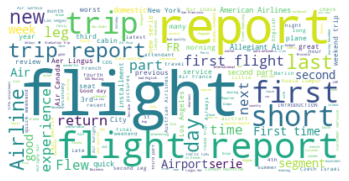

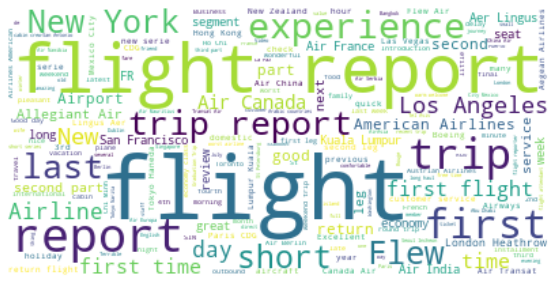

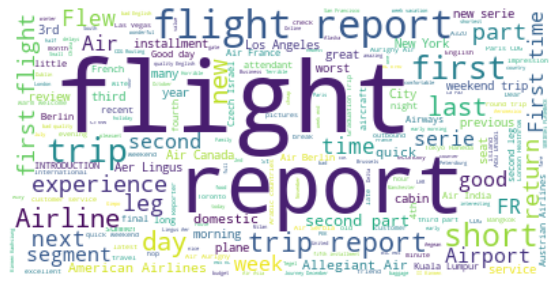

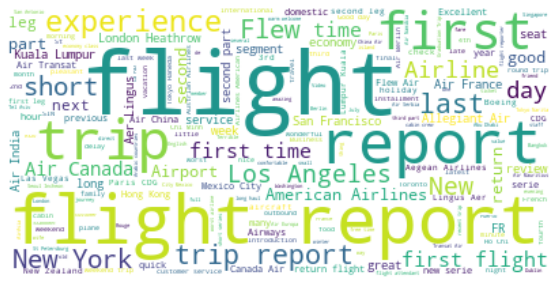

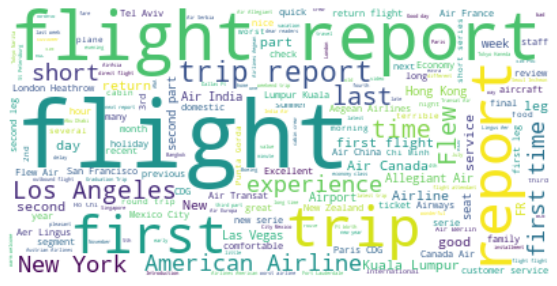

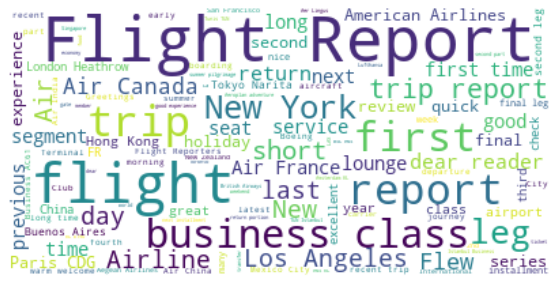

<Figure size 720x360 with 0 Axes>

In [117]:
# Running the dashboard

external_stylesheets = [dbc.themes.BOOTSTRAP]

app = dash.Dash(__name__, external_stylesheets=external_stylesheets)

app.layout = html.Div([
    dcc.Tabs(
        [dcc.Tab(label='What Contribute to Customer Satisfaction?', children=tab1),
         dcc.Tab(label='What do Customers Make of the Flights?', children=tab2),
         dcc.Tab(label='??', children=tab3)]
    )])

# Tab 1 interactivity
@app.callback(
    Output('chart_tab1', 'figure'),
    [Input('class_tab1', 'value'),
     Input('purpose_tab1', 'value'),
     Input('length_tab1', 'value'),
     Input('stop_tab1', 'value')])
def update_figure(seat_type, type_of_travaller, flight_length, stop):
    return output_chart_1(df_1, seat_type, type_of_travaller, stop, flight_length)

# Tab 2 interactivity 1 
@app.callback(
    Output('chart_spider_tab2', 'figure'),
    [Input('class_tab2', 'value'),
     Input('length_tab2', 'value')])
def update_figure(choice_class, choice_flight_length):
    return output_chart_2(df_2, choice_class, choice_flight_length)

# Tab 2 interactivity 2 
@app.callback(
    Output('chart_cloud_tab2', 'src'),
    [Input('class_tab2', 'value'),
     Input('length_tab2', 'value'),
     Input('chart_spider_tab2', 'clickData'),
     Input('pos_tab2', 'value')])
def update_figure(choice_class, choice_flight_length, clickData, choice_polarity):
    try:
        choice_topic = clickData['points'][0]['theta']
    except:
        choice_topic = 'Seat Comfort'
    print(choice_topic)
    
    try:
        output_chart_2_2(df_2_2, choice_class, choice_flight_length, choice_polarity=choice_polarity, choice_topic=choice_topic)
    except:
        pass
    
    image_path = path.join(data_path, 'cloud.png')
    encoded_image = base64.b64encode(open(image_path, 'rb').read()).decode('ascii')
    return 'data:image/png;base64,{}'.format(encoded_image)

    
if __name__ == '__main__':
    app.run_server(debug=False)